Missing values after filling: 0
MSE: 302.67129190758135
RMSE: 17.39745073013806


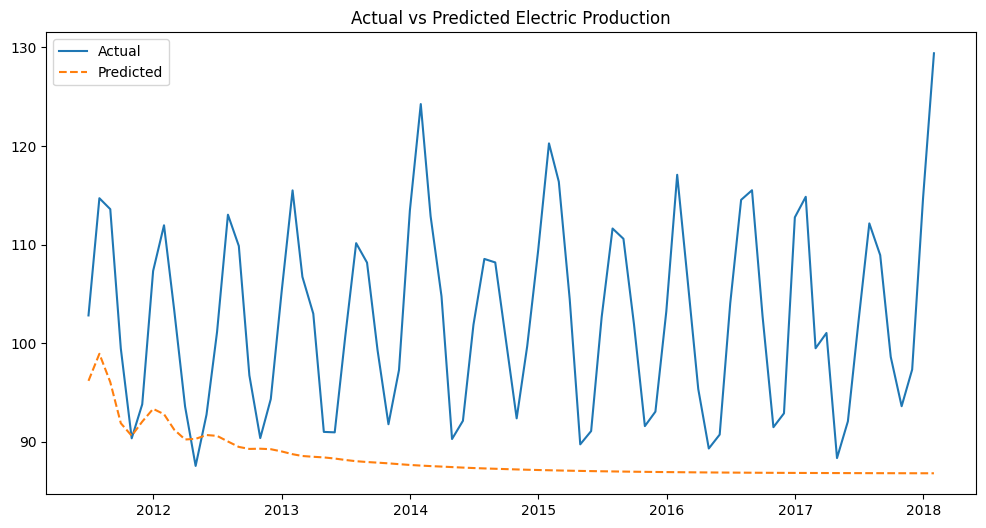

In [27]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("Electric_Production.csv")  # Ensure the correct file path

# Rename columns
df.rename(columns={'DATE': 'Date', 'IPG2211A2N': 'Electric_Production'}, inplace=True)

# Convert to datetime and set index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Resample to monthly frequency to ensure consistent timestamps
df = df.resample('ME').mean()  # This fills missing months with NaN first

# Fill missing values: First forward-fill, then backward-fill, then interpolate
df['Electric_Production'] = df['Electric_Production'].ffill().bfill()

# If missing values still exist, use interpolation
if df['Electric_Production'].isna().sum() > 0:
    df['Electric_Production'] = df['Electric_Production'].interpolate(method='linear')

# Check again for missing values
print("Missing values after filling:", df['Electric_Production'].isna().sum())

# Train-test split
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Ensure no missing or infinite values
train = train.replace([np.inf, -np.inf], np.nan).dropna()

# Fit AR model (p=3 based on PACF)
p = 3
if len(train) > p:
    from statsmodels.tsa.ar_model import AutoReg
    from sklearn.metrics import mean_squared_error
    import matplotlib.pyplot as plt

    model = AutoReg(train['Electric_Production'], lags=p).fit()
    predictions = model.predict(start=len(train), end=len(df) - 1, dynamic=False)

    # Evaluate model
    mse = mean_squared_error(test, predictions)
    rmse = np.sqrt(mse)
    print(f"MSE: {mse}")
    print(f"RMSE: {rmse}")

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(test, label='Actual')
    plt.plot(predictions, label='Predicted', linestyle='dashed')
    plt.legend()
    plt.title("Actual vs Predicted Electric Production")
    plt.show()
else:
    print("Not enough data points to fit AutoReg model.")
